In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from helper_functions_CART import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### 1. Load data and prepare data

In [2]:
admissions_df = pd.read_csv('../datasets/data/bar_pass_prediction.csv', index_col=False)
print(admissions_df.shape)
print(admissions_df.columns)
print(admissions_df.isnull().sum())
display(admissions_df.head())

(22407, 39)
Index(['decile1b', 'decile3', 'ID', 'decile1', 'sex', 'race', 'cluster',
       'lsat', 'ugpa', 'zfygpa', 'DOB_yr', 'grad', 'zgpa', 'bar1', 'bar1_yr',
       'bar2', 'bar2_yr', 'fulltime', 'fam_inc', 'age', 'gender', 'parttime',
       'male', 'race1', 'race2', 'Dropout', 'other', 'asian', 'black', 'hisp',
       'pass_bar', 'bar', 'bar_passed', 'tier', 'index6040', 'indxgrp',
       'indxgrp2', 'dnn_bar_pass_prediction', 'gpa'],
      dtype='object')
decile1b                   1604
decile3                    1604
ID                            0
decile1                    1092
sex                           5
race                         16
cluster                      96
lsat                          0
ugpa                          0
zfygpa                      984
DOB_yr                       50
grad                          3
zgpa                       1289
bar1                          0
bar1_yr                      39
bar2                          0
bar2_yr             

,decile1b,decile3,ID,decile1,sex,race,cluster,lsat,ugpa,zfygpa,...,hisp,pass_bar,bar,bar_passed,tier,index6040,indxgrp,indxgrp2,dnn_bar_pass_prediction,gpa
0,10.0,10.0,2,10.0,1.0,7.0,1.0,44.0,3.5,1.33,...,0,1,a Passed 1st time,True,4.0,886.842082,g 700+,i 820+,0.979804,3.5
1,5.0,4.0,3,5.0,1.0,7.0,2.0,29.0,3.5,-0.11,...,0,1,a Passed 1st time,True,2.0,649.999987,f 640-700,f 640-700,0.979804,3.5
2,3.0,2.0,36,3.0,2.0,7.0,3.0,36.0,3.5,-0.64,...,0,1,a Passed 1st time,True,3.0,760.526298,g 700+,h 760-820,0.979804,3.5
3,7.0,4.0,52,7.0,2.0,7.0,3.0,39.0,3.5,0.34,...,0,1,a Passed 1st time,True,3.0,807.894717,g 700+,h 760-820,0.979804,3.5
4,9.0,8.0,55,9.0,2.0,7.0,4.0,48.0,3.5,1.02,...,0,1,a Passed 1st time,True,5.0,949.999974,g 700+,i 820+,0.979804,3.5


In [3]:
# Remove all rows with missing values
#admissions_df = admissions_df.dropna()
print(admissions_df.shape)
print(admissions_df.isnull().sum())

(22407, 39)
decile1b                   1604
decile3                    1604
ID                            0
decile1                    1092
sex                           5
race                         16
cluster                      96
lsat                          0
ugpa                          0
zfygpa                      984
DOB_yr                       50
grad                          3
zgpa                       1289
bar1                          0
bar1_yr                      39
bar2                          0
bar2_yr                      40
fulltime                     34
fam_inc                     289
age                          89
gender                        5
parttime                     34
male                          5
race1                        16
race2                        16
Dropout                       0
other                         0
asian                         0
black                         0
hisp                          0
pass_bar                    

**UI text**

A subset of the [Law School Admission Bar*](https://www.kaggle.com/datasets/danofer/law-school-admissions-bar-passage) dataset is used as a demo. Synthetic data will be generated for the following columns: 

- sex: student gender, i.e. 1 (male), 2 (female)
- race1: race, i.e. asian, black, hispanic, white, other
- ugpa: The student's undergraduate GPA, continous variable;
- bar: Ground truth label indicating whether or not the student passed the bar, i.e. passed 1st time, passed 2nd time, failed, non-graduated

The CART method will be used  evaluate the distribution and correlation differences between the real and synthetic data.

*The original paper can be found [here](https://files.eric.ed.gov/fulltext/ED469370.pdf).

In [4]:
# demo dataset
real_data = admissions_df[['sex', 'race1', 'ugpa', 'bar']]
real_data = real_data.astype({'sex' : "category"})

real_data.head()

,sex,race1,ugpa,bar
0,1.0,white,3.5,a Passed 1st time
1,1.0,white,3.5,a Passed 1st time
2,2.0,white,3.5,a Passed 1st time
3,2.0,white,3.5,a Passed 1st time
4,2.0,white,3.5,a Passed 1st time


In [5]:
# automatically detect the data type of each column
dtypes_dict = real_data.dtypes.to_dict()
dtypes_dict

{'sex': CategoricalDtype(categories=[1.0, 2.0], ordered=False, categories_dtype=float64),
 'race1': dtype('O'),
 'ugpa': dtype('float64'),
 'bar': dtype('O')}

In [6]:
# replace 'float64' with 'float' and 'O' with 'object'
#dtypes_dict = {k: 'float' if v == 'float64' else 'category' if v == 'O' else v for k, v in dtypes_dict.items()}
dtypes_dict = {}
for k in real_data.dtypes.keys():
    match real_data.dtypes[k]:
        case 'float64':
            dtypes_dict[k] = 'float'
        case 'category':
            dtypes_dict[k] = 'category'
            real_data = real_data.astype({k : "category"})
        case _:
            dtypes_dict[k]= 'category'
            real_data = real_data.astype({k : "category"})
dtypes_dict


{'sex': 'category', 'race1': 'category', 'ugpa': 'float', 'bar': 'category'}

In [7]:

# Encode string columns to numeric values
# label_encoders = {}
# for column in real_data.select_dtypes(include=['object']).columns:
#     label_encoders[column] = LabelEncoder()
#     real_data[column] = label_encoders[column].fit_transform(real_data[column])
#
# real_data.head()

### 2. CART model

**UI text**

The CART (Classification and Regression Trees) method generates synthetic data by learning patterns from real data through a decision tree that splits data into homogeneous groups based on feature values. It predicts averages for numerical data and assigns the most common category for categorical data, using these predictions to create new synthetic points.

In [8]:
from notebooks.synthpop.synthpop import Synthpop
# Initialize Synthpop object with method 'cart'
from synthpop import *
spop = Synthpop()

# Fit the Synthpop model
spop.fit(real_data.copy(deep=False), dtypes_dict)

True2
True1
       sex  race1  ugpa                bar
0      1.0  white   3.5  a Passed 1st time
1      1.0  white   3.5  a Passed 1st time
2      2.0  white   3.5  a Passed 1st time
3      2.0  white   3.5  a Passed 1st time
4      2.0  white   3.5  a Passed 1st time
...    ...    ...   ...                ...
22402  2.0  black   1.8           c Failed
22403  2.0  black   1.8           c Failed
22404  2.0  black   1.8  a Passed 1st time
22405  2.0  white   1.5  a Passed 1st time
22406  2.0  white   1.6  a Passed 1st time

[22407 rows x 4 columns]
train_sex
train_race1
train_ugpa
train_bar


I:\Team Data-Science\Leden\Erina\AAlocalFirstWebtool\notebooks\synthpop\processor\processor.py:62: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(col_nan_category, inplace=True)
I:\Team Data-Science\Leden\Erina\AAlocalFirstWebtool\notebooks\synthpop\processor\processor.py:62: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on 

In [9]:
gen_data = spop.generate(k=real_data.shape[0])
gen_data

generate_sex
generate_race1
generate_ugpa
generate_bar


,sex,race1,ugpa,bar
0,2.0,white,3.2,b Passed 2nd time
1,1.0,white,2.9,a Passed 1st time
2,2.0,white,3.6,a Passed 1st time
3,1.0,white,3.8,a Passed 1st time
4,2.0,hisp,2.7,a Passed 1st time
...,...,...,...,...
22402,2.0,white,2.9,a Passed 1st time
22403,2.0,white,3.3,a Passed 1st time
22404,2.0,white,3.5,c Failed
22405,2.0,white,2.7,a Passed 1st time


### 3. Evaluation of generated data

@erina

sex


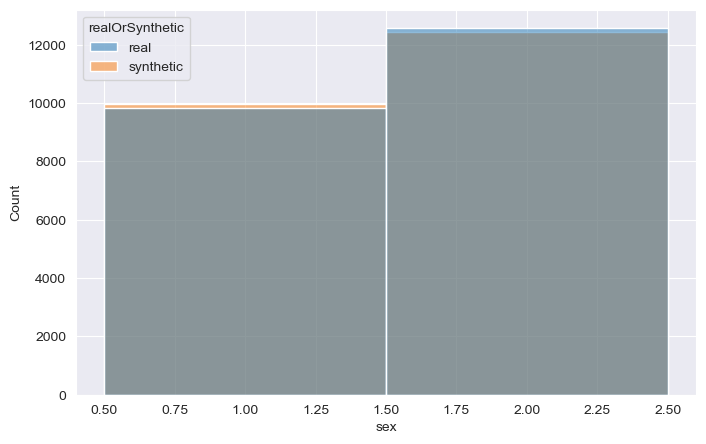

race1


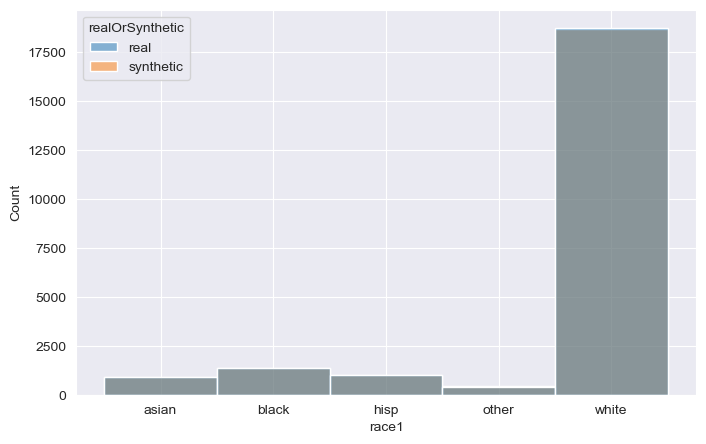

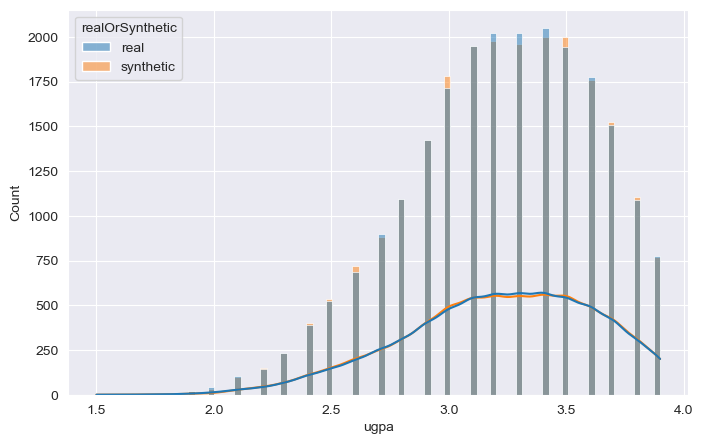

bar


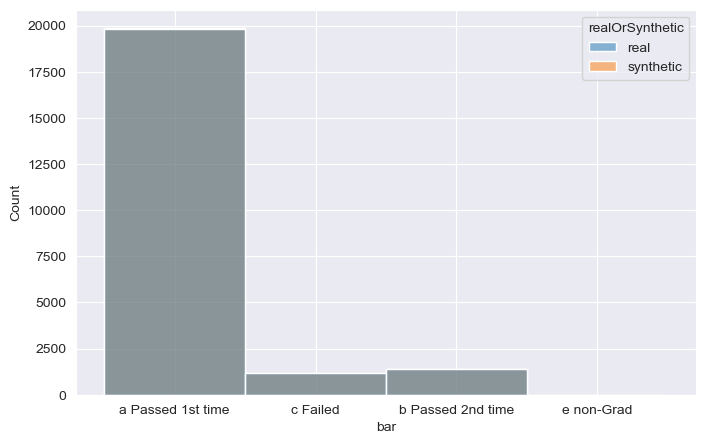

In [12]:
combined_data = pd.concat((real_data.assign(realOrSynthetic='real'),gen_data.assign(realOrSynthetic='synthetic')),keys=['real','synthetic'],names=['realOrSynthetic'])

for column_name in real_data.columns:
    if dtypes_dict[column_name]=='float':
        plt.figure(figsize=(8, 5))
        sns.histplot(data=combined_data,
                     x= column_name,
                     kde=True,
                     stat="count",
                     hue='realOrSynthetic',
                     )
        plt.show()
    else:
        print(column_name)
        plt.figure(figsize=(8, 5))
        sns.histplot(data=combined_data,
                     x= column_name,
                     stat="count",
                     hue='realOrSynthetic',
                     discrete=True
                     )
        plt.show()
#bins tegen elkaar, alpha waarde voor overlap
# for column_name in categorical_columns:
#     plt.figure(figsize=(8, 5))
#     sns.histplot(data=combined_data,
#                  x= column_name,
#                  stat="count",
#                  hue='realOrSynthetic',
#                  discrete=True
#                  )
#     plt.show()

<Figure size 800x500 with 0 Axes>

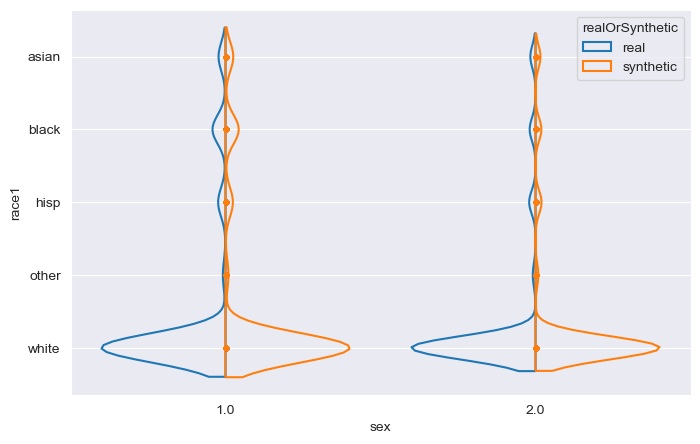

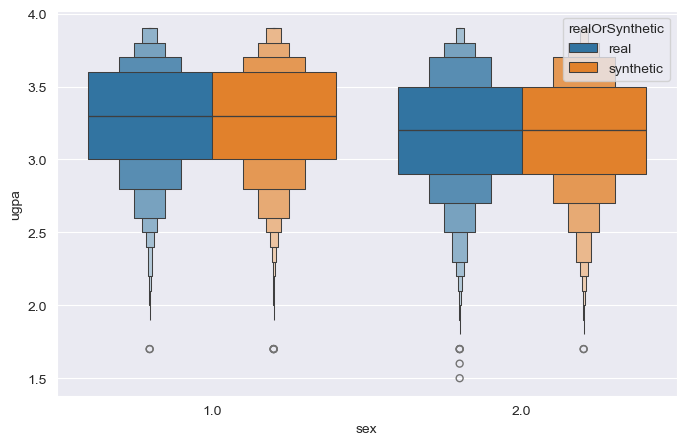

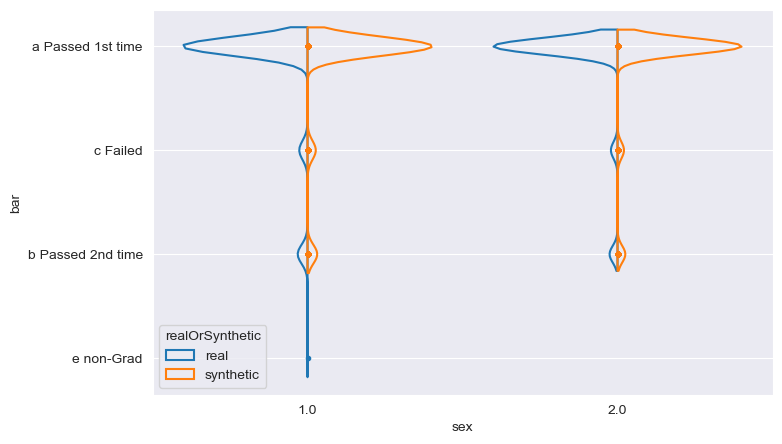

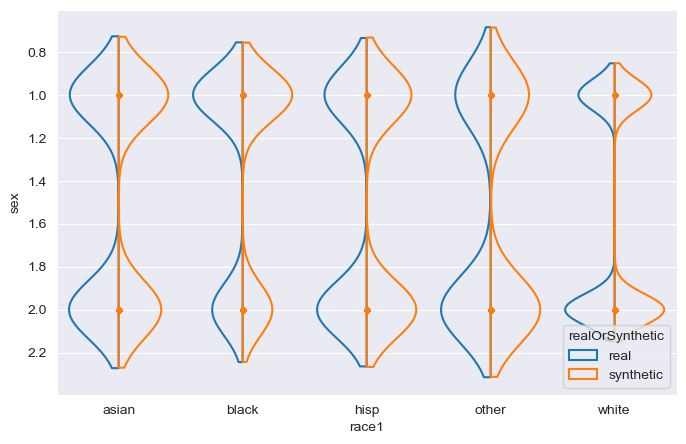

<Figure size 800x500 with 0 Axes>

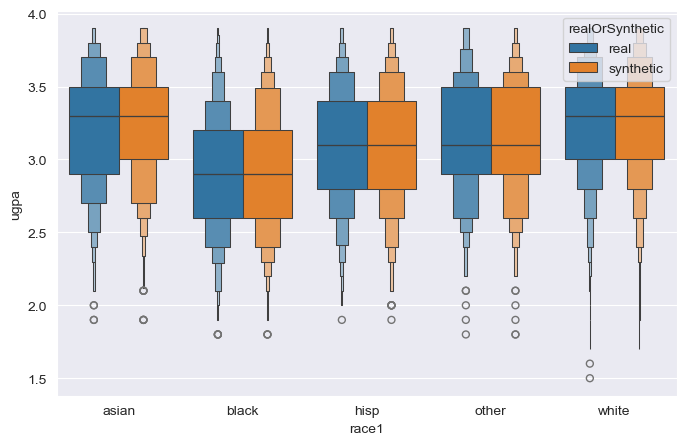

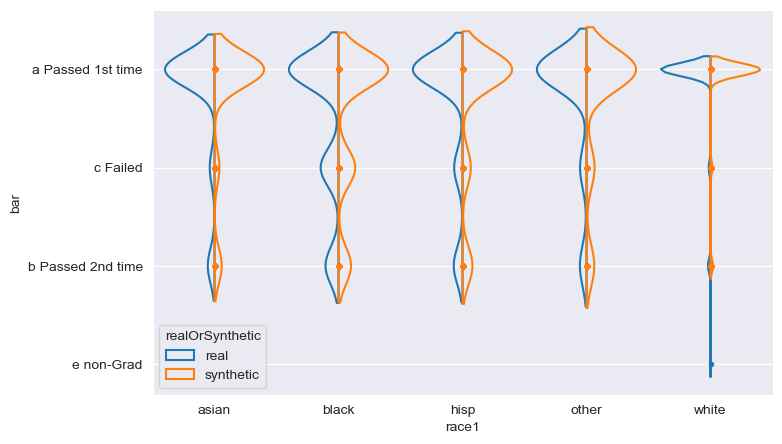

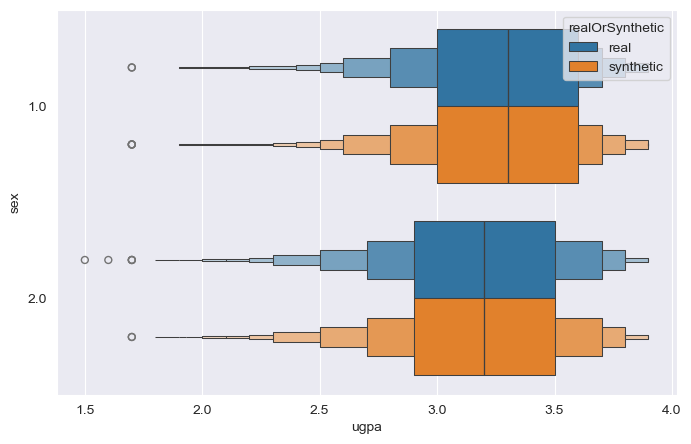

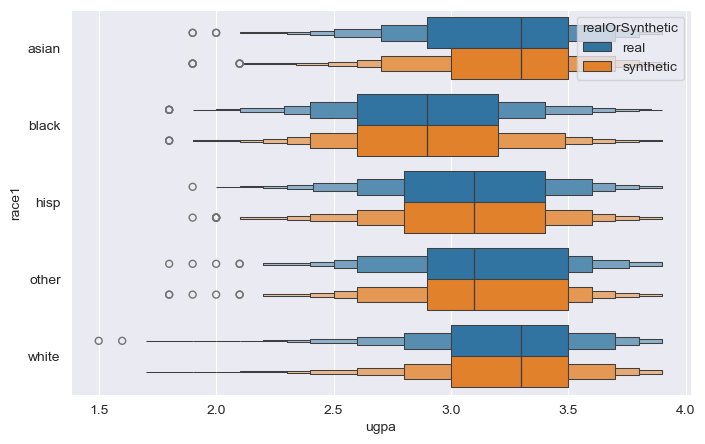

<Figure size 800x500 with 0 Axes>

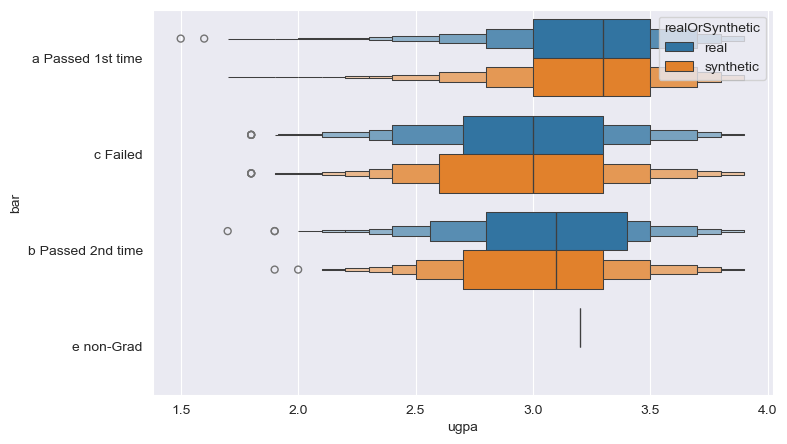

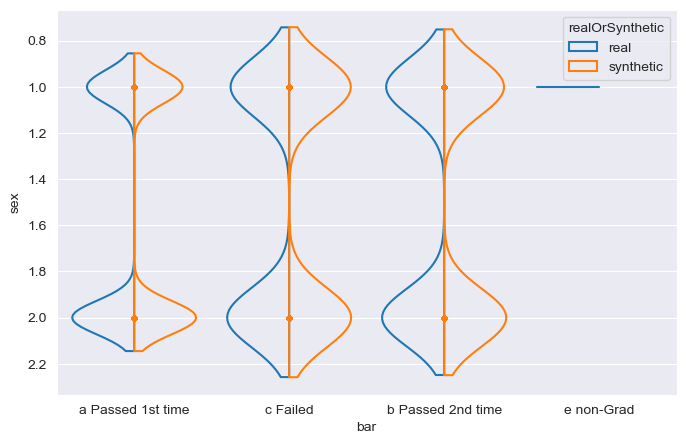

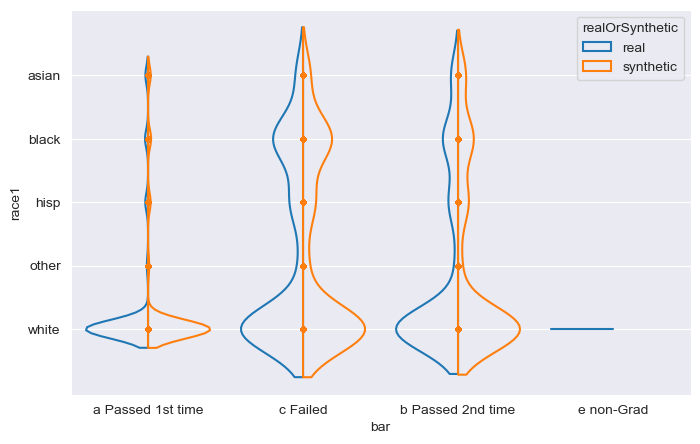

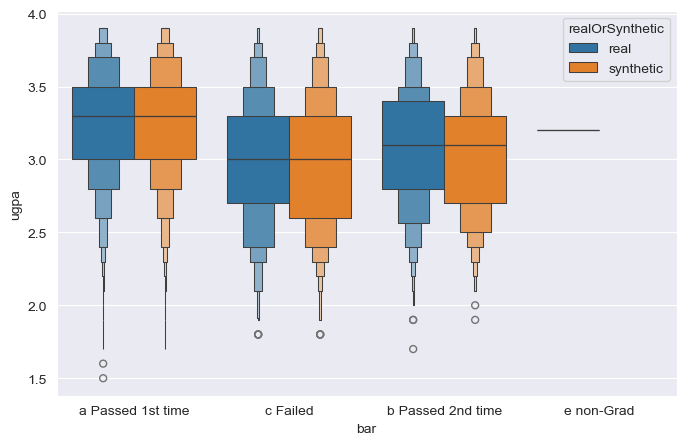

<Figure size 800x500 with 0 Axes>

In [49]:
number_of_columns = real_data.shape[1]
number_of_columns

#g = sns.PairGrid(combined_data,hue='realOrSynthetic')
def compare_plot(*args,**kwargs):
    print("call")
    print(*args)
    return sns.boxplot(**kwargs)

#sns.catplot(data = combined_data)
#g.map(compare_plot)
#fig,axis = plt.subplots(number_of_columns,number_of_columns,sharex="row",sharey="col")

for c1 in range(number_of_columns):
    for c2 in range(number_of_columns):
        plt.figure(figsize=(8, 5))
        column_name1 = combined_data.columns[c1]
        column_name2 = combined_data.columns[c2]
        #print(dtypes_dict[column_name1]+dtypes_dict[column_name2])

        if c1 == c2:
            continue
        if dtypes_dict[column_name1] == 'category' and dtypes_dict[column_name2] == 'category':
            sns.violinplot( data=combined_data, x=column_name1, y=column_name2,hue='realOrSynthetic',
                            inner="point",
                            dodge=True,
                            fill=False,
                            split=True,
                            density_norm="width",
                            bw_method="silverman",
                            common_norm=True,
                            #bw_adjust=0.01
                            )
            #print(column_name1+column_name2)
        elif dtypes_dict[column_name1] == 'category' or dtypes_dict[column_name2] == 'category':
            #print("!!!!")
            sns.boxenplot( data=combined_data, x=column_name1, y=column_name2,hue='realOrSynthetic')

            #sns.move_legend(axis[c1, c2], "upper left", bbox_to_anchor=(.55, .45), frameon=False)

#fig.legend(loc='outside upper right')